# Обработка результатов

In [1]:
import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
%matplotlib notebook
from lab import *
f = lambda x, a, b: a*x + b

In [2]:
data = {}
eta = 1.83e-5; h = 1e-3; g = 9.8; rho = 898; l = 7.25e-3
for i in range(1, 11):
    table = pd.read_csv('drop' + str(i) + '.csv', sep=';')
    data['drop' + str(i)] = table
    
data['tinf'] = pd.read_csv('tinf.csv', sep=';')

## Рассчитаем заряд каждой капли.
Для этого воспользуемся формулой (11):
$$ q = 9\pi\sqrt\frac{2\eta^3h^3}{g\rho}\cdot\frac{l(t_0 + t)}{Vt_0^{3/2}t} . $$
Отложим эти значения на горизонтальной числовой оси.

<IPython.core.display.Javascript object>


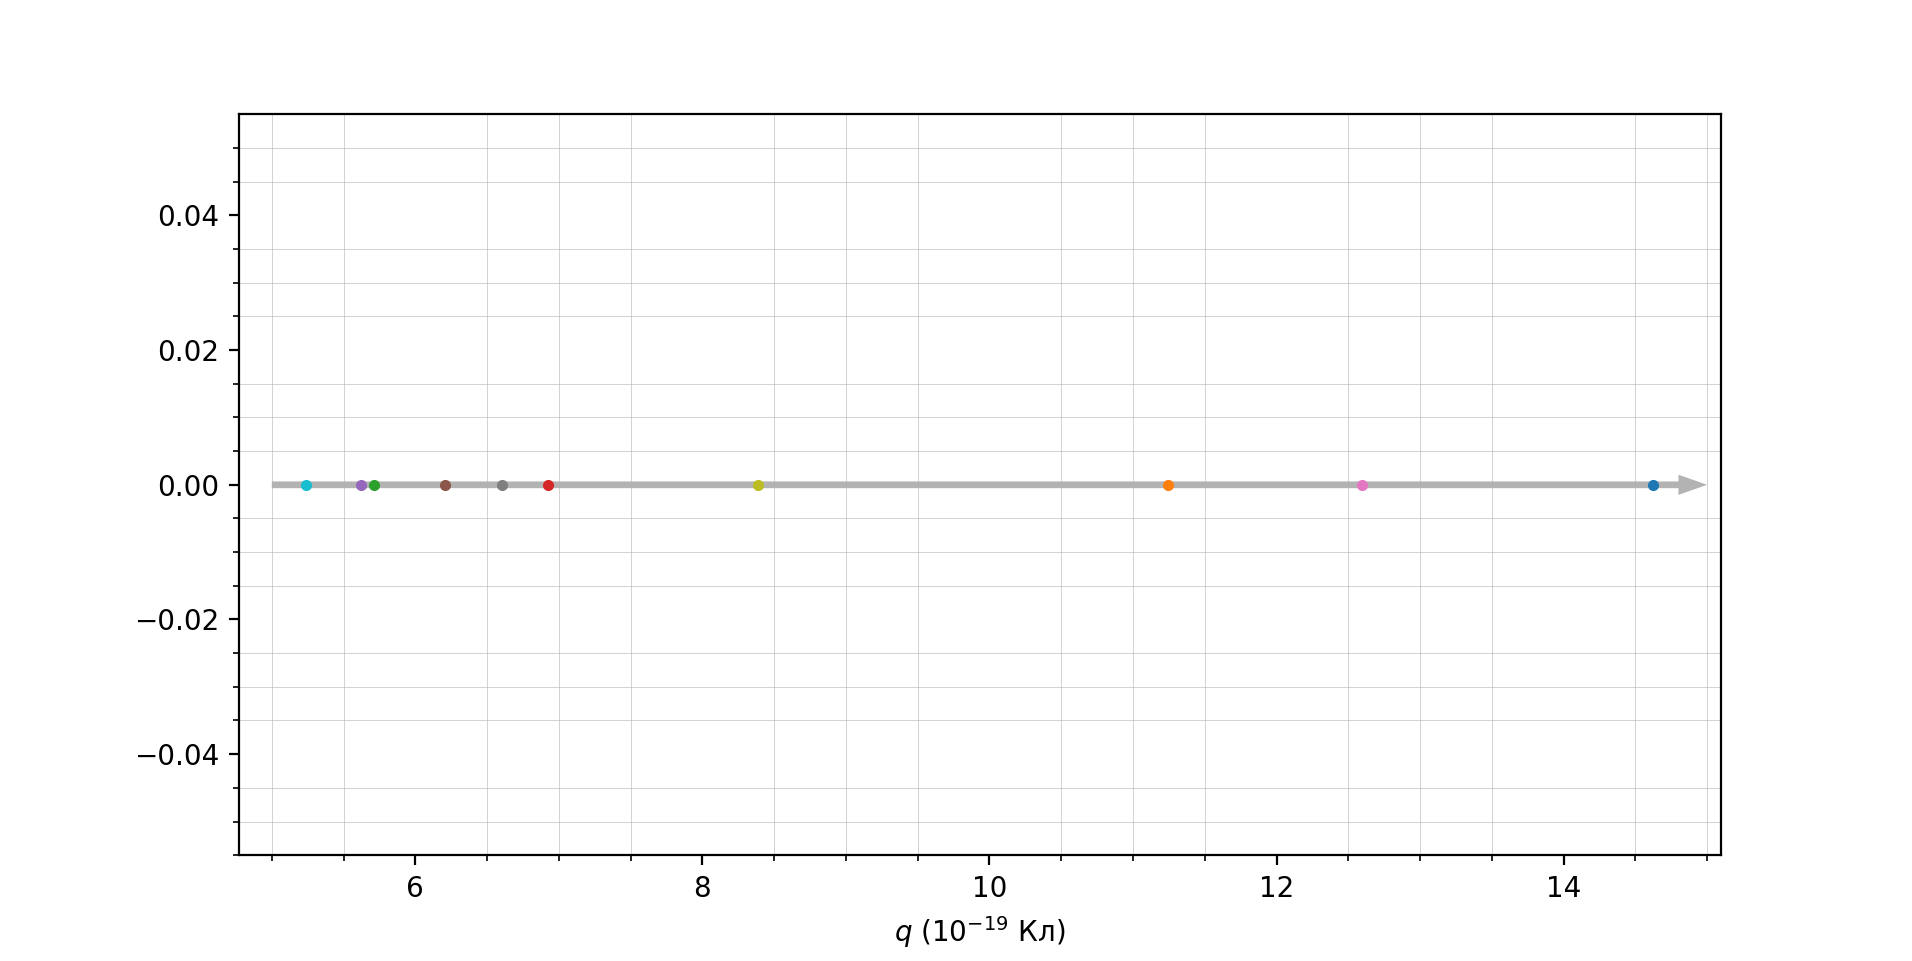

Заряды капель (*10^-19 Кл):
14.63 11.25 5.71 6.92 5.62 6.21 12.59 6.61 8.39 5.24


In [4]:
q = []
for i in range(1, 11):
    d = np.transpose(np.array(data['drop' + str(i)]))
    t_0 = d[0]
    t = d[1]
    V = d[2]
    q_i = 9*math.pi * math.sqrt(2*(eta*h)**3 / (g*rho)) * l*(t_0+t) / (V * t_0**(3/2) * t)
    q_i = np.mean(q_i)
    q.append(q_i)
    create_plot('$q$ ($10^{-19}$ Кл)', '')
    plt.plot([q_i*1e19], [0], linestyle='', marker='.')
plt.axes().arrow(5, 0, 9.8, 0, linewidth=1e-10, head_width=3e-3, head_length=0.2, color='0.7')
q = np.array(q)
print('Заряды капель (*10^-19 Кл):')
print(*np.round(q * 1e19, 2))

## Найдем значение элементарного заряда $e$.
Сделаем это несколькими способами.

**Способ 1.** Оценим, как соотносятся заряды капель, посмотрев на них.

In [5]:
supp = np.array([9, 7, 4, 4, 4, 4, 8, 4, 5, 3])
print('Предполагаемые заряды (e):')
print(*supp, '\n')
print('e'+7*' '+'=', round(np.mean(q / supp) * 1e19, 4), '*10^-19 Кл')
print('sigma e =', round(np.std(q / supp) * 1e19, 4), ' *10^-19 Кл')
print('eps e'+3*' '+'=', round(np.std(q / supp) / (np.mean(q / supp)), 4))

Предполагаемые заряды (e):
9 7 4 4 4 4 8 4 5 3 

e       = 1.5997 *10^-19 Кл
sigma e = 0.109  *10^-19 Кл
eps e   = 0.0681


$$e = (1,6 \pm 0,1) \cdot 10^{-19} \ \text{Кл}$$

**Способ 2.** Разделим заряды капель на предполагаемый заряд электрона.

In [6]:
qq = [int(round(x)) for x in q * 1e19 / 1.6]
e = np.mean(q / qq)
#print(np.round(q * 1e19, 2))
#print(qq)
print('Заряды капель в предполагаемых зарядах электрона (округлим до целых значений):')
print(*np.round(q / e, 2), '\n')
print('e'+7*' '+'=', round(e * 1e19, 4), '*10^-19 Кл')
print('sigma e =', round(np.std(q / qq)*1e19, 4), ' *10^-19 Кл')
print('eps e'+3*' '+'=', round(np.std(q / qq) / e, 4))

Заряды капель в предполагаемых зарядах электрона (округлим до целых значений):
9.14 7.03 3.57 4.33 3.51 3.88 7.87 4.13 5.24 3.28 

e       = 1.5997 *10^-19 Кл
sigma e = 0.109  *10^-19 Кл
eps e   = 0.0681


$$e = (1,6 \pm 0,1) \cdot 10^{-19} \ \text{Кл}$$

Как можно видеть, результаты первых двух способов оказались одинаковыми.

**Способ 3.** Напишем программу для нахождения НОД дробных чисел с некоторой погрешностью $\varepsilon$.

In [7]:
def f_gcd(a, b, eps) : 
    if (a < b): 
        return f_gcd(b, a, eps)  
    if (abs(b) < 2 * eps): 
        return a 
    else: 
        return f_gcd(b, a - math.floor(a / b) * b, eps) 
    
def f_gcd_(a, eps):
    res = a[0]
    for i in range(1, len(a)):
        res = f_gcd(res, a[i], eps)
    return res

In [8]:
eps = 0.56
e = f_gcd_(q * 1e19, eps)
print('e'+7*' '+'=', round(e, 4), '*10^-19 Кл')
print('sigma e =', round(eps, 4), ' *10^-19 Кл')
print('eps e'+3*' '+'=', round(eps / e, 3))

e       = 1.559 *10^-19 Кл
sigma e = 0.56  *10^-19 Кл
eps e   = 0.359


$$e = (1,56 \pm 0,56) \cdot 10^{-19} \ \text{Кл}$$

## Оценим максимальный путь релаксации $s$.
Для этого воспользуемся формулой
$$s < v_\text{уст}\tau = \frac{1}{g}\left(\frac{h}{t_0}\right)^2 .$$

In [9]:
s_max = 0
for i in range(1, 11):
    d = np.transpose(np.array(data['drop' + str(i)]))
    t_0 = d[0]
    s = (1/g) * (h/t_0)**2
    if max(s) > s_max:
        s_max = max(s)
print('s max =', round(s_max * 1e10, 2), 'Å')

s max = 8.43 Å


# Результат
С использованием теоретического значения
$$e_t = (1,6 \pm 0,1) \cdot 10^{-19} \ \text{Кл},$$
без использования
$$e_e = (1,56 \pm 0,56) \cdot 10^{-19} \ \text{Кл}.$$

# Вывод

В данной работе методом масляных капель было экспериментально получено значение элементарного заряда и с более высокой точностью подтвердились известные ранее результаты. Мы предполагали, что при достаточно большом числе измерений значения зарядов всех капель в единицах элементарного заряда оказались взаимно просты. Полученные с использованием известных результатов и полностью экспериментально значения, даже несмотря на меньшую точность последних, практически совпадают со значением, полученным самим Милликеном (около $1,59\cdot10^{-19}$ Кл), что подтверждает наше предположение.